In [13]:
import asset_loader

from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
from tqdm import tqdm
import itertools


from importlib import reload

c:\Users\otkul\sintef\repo\qaoa\examples\PortfolioOptimization\asset_loader.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


256


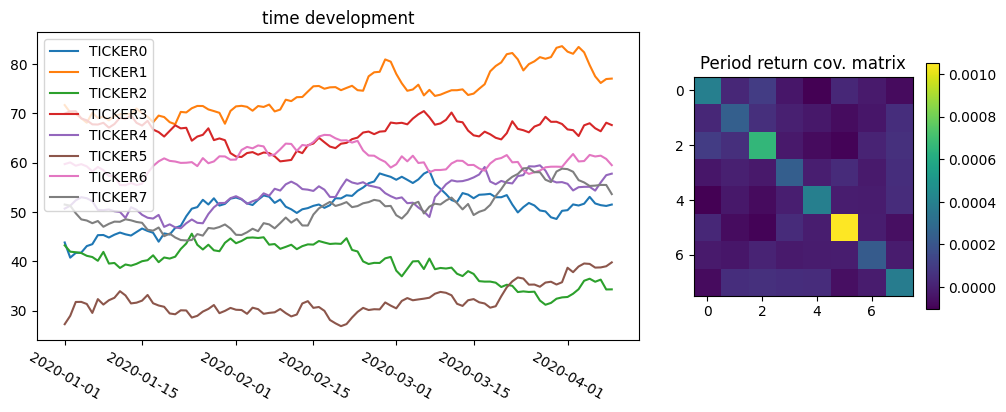

In [14]:
reload(asset_loader)
assets = asset_loader.AssetData(8, 100, seed=13)
assets.plotAssets()

params = {
    "risk" : 0.5,
    "budget": 3,
    "penalty": 0.1,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return,
    "usebarrier": True
}
print(2**assets.N)

In [15]:
from qaoa import QAOA, problems, mixers

qaoa_portopt = QAOA(
    problem=problems.PortfolioOptimization,
    mixer=mixers.XY,
    params=params
)

Its now computing the feasible subspace


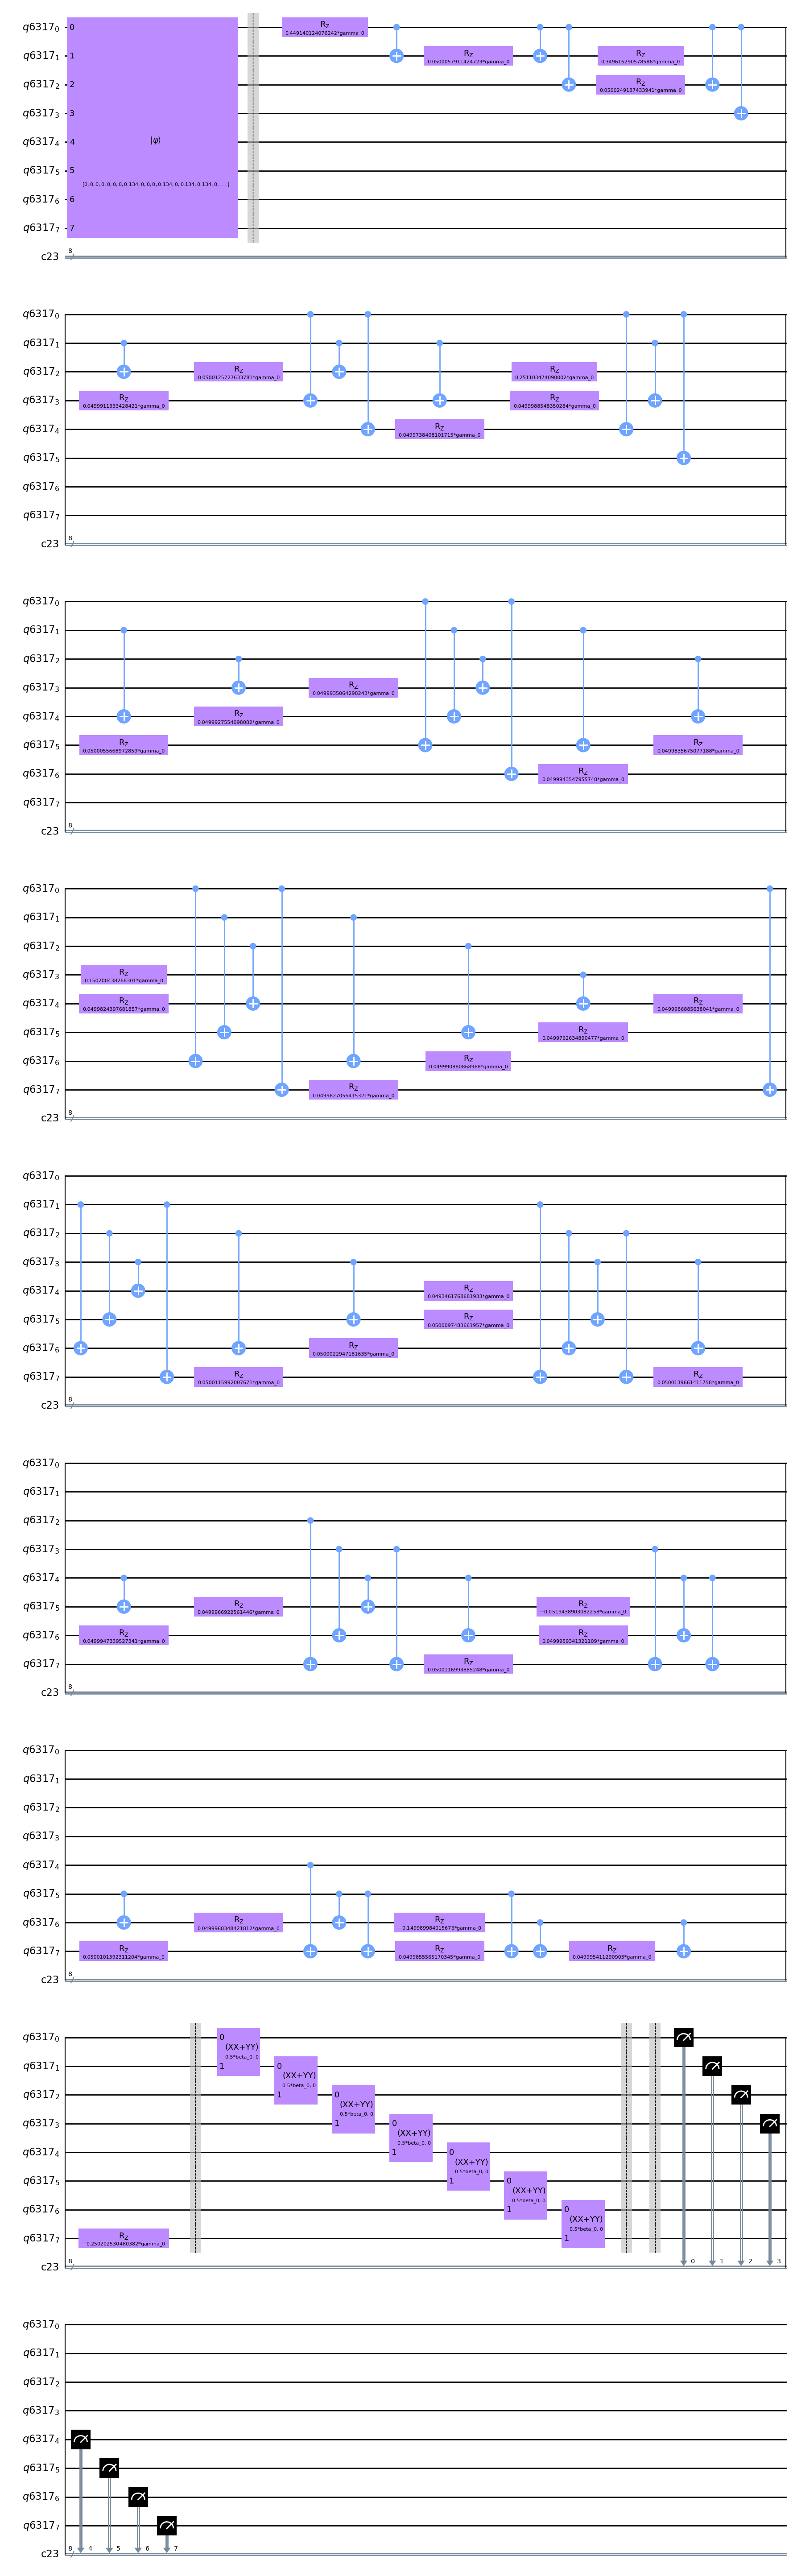

In [16]:

qaoa_portopt.createParameterizedCircuit(1)
display(qaoa_portopt.parameterized_circuit.draw(output='mpl'))

In [17]:

print("solutions:")
best_sol = None
best_cost = None
for s in [''.join(i) for i in itertools.product('01', repeat = assets.N)]:
    c = qaoa_portopt.cost(s)
    if best_sol is None:
        best_sol = s
        best_cost = c
    elif c > best_cost:
        best_sol = s
        best_cost = c

    if qaoa_portopt.isFeasible(s):
        print(s, c)
    else: 
        print(s, '\t', c)

print("--------------------")
print("Best sol is "+ best_sol + " with cost " + str(best_cost))

solutions:
00000000 	 -0.9000000000000001
00000001 	 -0.39959493903923593
00000010 	 -0.40003838680503623
00000011 	 -0.09961497100788397
00000100 	 -0.3961826539466855
00000101 	 -0.09571981905405957
00000110 	 -0.09620838012044663
00000111 0.004272809608567574
00001000 	 -0.3986812912588831
00001001 	 -0.09831678722260051
00001010 	 -0.09870341459236309
00001011 0.0016794442803076404
00001100 	 -0.0948507142301469
00001101 0.005571563737997387
00001110 0.005139823067648375
00001111 	 -0.09441954412781906
00010000 	 -0.4003413954515679
00010001 	 -0.09998313204490306
00010010 	 -0.10035871806754038
00010011 1.79001755127306e-05
00010100 	 -0.09656304286303585
00010101 0.003852994475491034
00010110 0.003432295152266618
00010111 	 -0.09613331267281877
00011000 	 -0.09901744096566722
00011001 0.0013002655165161858
00011010 0.0009814998899163596
00011011 	 -0.09868243879151195
00011100 0.004774142598286457
00011101 	 -0.0948503769876683
00011110 	 -0.09521425591485522
00011111 	 -0.394820

## Sample cost landscape

In [18]:
qaoa_portopt.sample_cost_landscape(angles={"gamma": [0,np.pi,50], "beta": [0,np.pi,40]})

2023-09-06 11:58:10 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:58:10 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:58:10 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:58:10 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:58:33 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:58:33 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


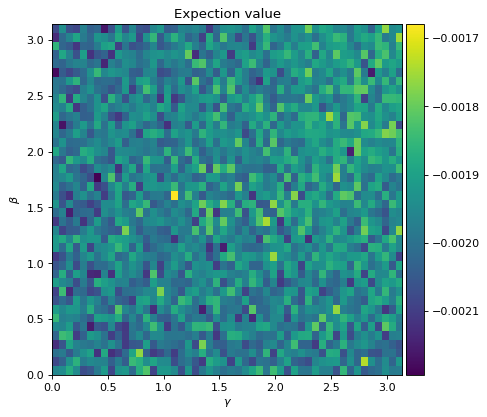

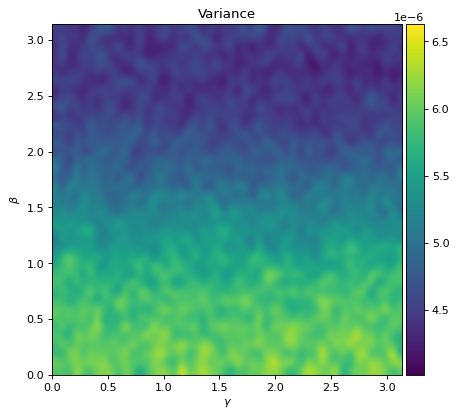

In [19]:
def plotLandscape(field, title, interpolation='bicubic'):
    f = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
    _=plt.xlabel(r'$\gamma$')
    _=plt.ylabel(r'$\beta$')
    ax = plt.gca()
    _=plt.title(title)
    im = ax.imshow(field, interpolation=interpolation, origin='lower', extent=[0,np.pi,0,np.pi])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    _=plt.colorbar(im, cax=cax)

plotLandscape(qaoa_portopt.E, "Expection value", interpolation="None")
#plotLandscape(qaoa_portopt.E, r'CVaR with $\alpha$='+str(qaoaec_cvar.params["alpha"])) #, interpolation="None")
plotLandscape(qaoa_portopt.Var, "Variance")


In [20]:
def searchBestSolution(qaoa, depth, verbose=0):
    # Verbose: 0 = None, 1 = Best only, 2 = all
    hist=qaoa.hist(qaoa.angles_hist['d'+str(depth)+'_final'])
    sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

    if verbose > 1: print("Classical best result: ", (best_sol, best_cost))

    i = 0
    best_s = None
    best_freq = None
    best_i = None
    best_c = None
    for s, freq in sorted_hist.items():
        if s == best_sol:
            if verbose > 1: print(str(i)+" -->\t", qaoa.cost(s), s, freq)
            best_s, best_freq, best_i = s, freq, i
            best_c = qaoa.cost(best_s)
        elif i <= 30:
            if qaoa_portopt.isFeasible(s):
                if verbose > 1: print(str(i)+"\t", qaoa.cost(s), s, freq)
            else:
                if verbose > 1: print(str(i)+"\t\t", qaoa.cost(s), s, freq)
        i = i + 1
    if best_s is not None:
        if verbose > 0: print("Best sol (rank, cost, freq):", (best_i, qaoa.cost(best_s), best_freq))

    
    return best_s, best_freq, best_i, best_c

In [21]:
qaoa_portopt.angles_hist

{}

In [22]:
maxdepth=10
for i in tqdm(range(maxdepth)):
    qaoa_portopt.increase_depth()
    searchBestSolution(qaoa_portopt, i+1, verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

2023-09-06 11:58:35 [info     ] cost(depth 1 = -0.0019041979242302917 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (51, 0.006864651880631345, 1)


 10%|█         | 1/10 [00:01<00:13,  1.48s/it]

2023-09-06 11:58:40 [info     ] cost(depth 2 = -0.002567345061130194 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (46, 0.006864651880631345, 1)


 20%|██        | 2/10 [00:06<00:26,  3.32s/it]

2023-09-06 11:58:50 [info     ] cost(depth 3 = -0.002511651116414697 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (43, 0.006864651880631345, 1)


 30%|███       | 3/10 [00:16<00:46,  6.61s/it]

2023-09-06 11:59:04 [info     ] cost(depth 4 = -0.002336950298481661 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (42, 0.006864651880631345, 1)


 40%|████      | 4/10 [00:30<00:56,  9.50s/it]

2023-09-06 11:59:26 [info     ] cost(depth 5 = -0.0027793321173042 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (30, 0.006864651880631345, 5)


 50%|█████     | 5/10 [00:52<01:09, 13.83s/it]

2023-09-06 11:59:47 [info     ] cost(depth 6 = -0.0026714244482281156 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (26, 0.006864651880631345, 7)


 60%|██████    | 6/10 [01:13<01:05, 16.25s/it]

2023-09-06 12:00:14 [info     ] cost(depth 7 = -0.002889632954841184 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (30, 0.006864651880631345, 3)


 70%|███████   | 7/10 [01:40<01:00, 20.03s/it]

2023-09-06 12:00:49 [info     ] cost(depth 8 = -0.002520260469779789 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (30, 0.006864651880631345, 4)


 80%|████████  | 8/10 [02:15<00:49, 24.61s/it]

2023-09-06 12:01:32 [info     ] cost(depth 9 = -0.0026117594736138716 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (13, 0.006864651880631345, 23)


 90%|█████████ | 9/10 [02:58<00:30, 30.57s/it]

2023-09-06 12:02:38 [info     ] cost(depth 10 = -0.003165917222741273 file=qaoa.qaoa func=increase_depth
Best sol (rank, cost, freq): (32, 0.006864651880631345, 5)


100%|██████████| 10/10 [04:04<00:00, 24.43s/it]


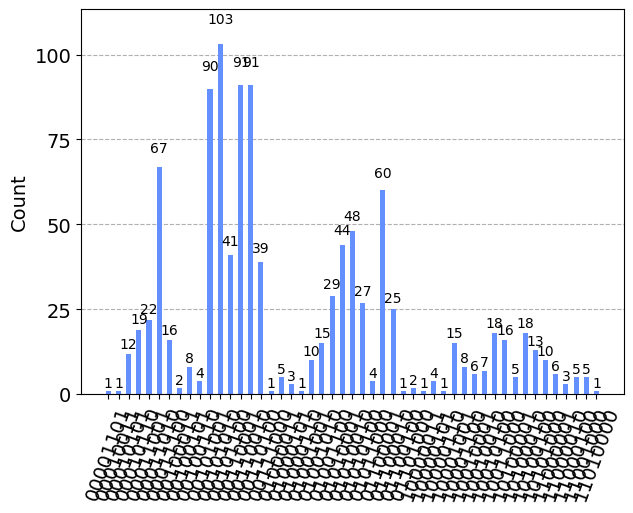

In [23]:
hist=qaoa_portopt.hist(qaoa_portopt.angles_hist['d'+str(maxdepth)+'_final'])
plot_histogram(hist)

In [24]:
sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

print("Classical best result: ", (best_sol, best_cost))

i = 0
best_s = None
best_freq = None
best_i = None
for s, freq in sorted_hist.items():
    if s == best_sol:
        print(str(i)+" -->\t", qaoa_portopt.cost(s), s, freq)
        best_s, best_freq, best_i = s, freq, i
    elif i <= 30:
        if qaoa_portopt.isFeasible(s):
            print(str(i)+"\t", qaoa_portopt.cost(s), s, freq)
        else:
            print(str(i)+"\t\t", qaoa_portopt.cost(s), s, freq)
    i = i + 1
if best_s is not None:
    print("Best sol (rank, cost, freq):", (best_i, qaoa_portopt.cost(best_s), best_freq))




Classical best result:  ('10001100', 0.006864651880631345)
0	 -0.0009754185321749764 00101010 103
1	 -0.002346088323319062 00110001 91
2	 -0.002674988653907584 00110010 91
3	 -0.0006354768544618583 00101001 90
4	 0.0009814998899163596 00011010 67
5	 -0.0013522162694326045 01100001 60
6	 0.00041068030197688454 01010010 48
7	 0.0007033929974180619 01010001 44
8	 0.002981406746504489 00101100 41
9	 0.0012248114670603272 00110100 39
10	 0.005972335285247765 01001100 29
11	 

0.00423560895147812 01010100 27
12	 -0.0016661050159870738 01100010 25
13	 0.0013002655165161858 00011001 22
14	 0.003432295152266618 00010110 19
15	 0.005083153117060091 10010100 18
16	 -0.0008247288873731717 10100010 18
17	 0.004774142598286457 00011100 16
18	 0.0027556593628862425 10011000 16
19	 0.002090381478034975 01001010 15
20	 0.003490024311193052 10001001 15
21	 0.0030902804805961193 10100100 13
22	 0.003852994475491034 00010101 12
23	 0.0006938424003043453 10101000 10
24	 0.0023941355206010817 01001001 10
25	 0.0019861964306309154 00100101 8
26 -->	 0.006864651880631345 10001100 8
27	 0.0013323263194000567 10010010 7
28	 0.0027660155477891024 11000001 6
29	 0.0017545093582085336 10010001 6
30	 0.00110344989867861 01000011 5
Best sol (rank, cost, freq): (26, 0.006864651880631345, 8)
